In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [3]:
veriler = []
etiketler = []
siniflar = 43
simdikiDosyaDizini = os.getcwd()


# Görüntüleri ve etiketleri yükleme
for i in range(siniflar):
    dizin = os.path.join(simdikiDosyaDizini, 'train', str(i))
    fotograflar = os.listdir(dizin)

    for a in fotograflar:
        try:
            fotograf = Image.open(dizin + '\\' + a)
            fotograf = fotograf.resize((30, 30))
            fotograf = np.array(fotograf)
            veriler.append(fotograf)
            etiketler.append(i)
        except:
            print("Görüntü yükleme hatası")

# Listeyi numpy dizilerine çevirme
veriler = np.array(veriler)
etiketler = np.array(etiketler)

In [4]:
print(veriler.shape, etiketler.shape)
# Verisetini test ve eğitim verisi olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(veriler, etiketler, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [5]:
# y_train ve x_train de bulunan verileri sıcak kodlamaya dönüştürmek için to_catecorical yöntemini kullanıyoruz.
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [6]:
from keras.layers import MaxPooling2D
# CNN Modeli oluşturuyoruz.
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu',
                 input_shape=X_train.shape[1:]))  
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Model derlemesi için Adam optimizer kullanıyoruz . Kayıp fonksiyonu "catecorical_crossentropy" dir. Çünkü
# kategorize etmemiz gereken birden fazla sınıf var.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [7]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

kayitNoktasi = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')## Eğitim sırasında en iyi model kaydedilir

erkenDurdurma = EarlyStopping(monitor='val_loss', ##modelin eğitimi sırasında model eğitimi yavaşladığında erken durdurma uygulanır
                          min_delta=0,
                          patience=3,#sabır 
                          verbose=1,
                          restore_best_weights=True
                          )

ogrenmeOraniAzalt = ReduceLROnPlateau(monitor='val_loss',## öğrenme oranı azalmakta ve minimum noktaya daha fazla yaklaşma yapmaktadır.
                              factor=0.2,
                              patience=4,
                              verbose=1,
                              min_delta=0.0001)

callbackListesi = [erkenDurdurma,kayitNoktasi,ogrenmeOraniAzalt]

In [9]:
epochs = 30 # epoch sayısını en optimize şekilde tutmak önemlidir. Overfitting'e sebep olabilir.
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=callbackListesi)



Epoch 1/30
981/981 [==============================] - 68s 70ms/step - loss: 1.9096 - accuracy: 0.4933 - val_loss: 0.5281 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 2/30
981/981 [==============================] - 73s 74ms/step - loss: 0.7223 - accuracy: 0.7908 - val_loss: 0.2428 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 3/30
981/981 [==============================] - 71s 73ms/step - loss: 0.4826 - accuracy: 0.8594 - val_loss: 0.1714 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 4/30
981/981 [==============================] - 73s 74ms/step - loss: 0.3657 - accuracy: 0.8974 - val_loss: 0.1071 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 5/30
981/981 [==============================] - 76s 77ms/step - loss: 0.3208 - accuracy: 0.9085 - val_loss: 0.1260 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 6/30
981/981 [==============================] - 80s 81ms/step - loss: 0.2768 - accuracy: 0.9258 - val_loss: 0.1077 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 7/30
981/981 [==============================] - 80s 

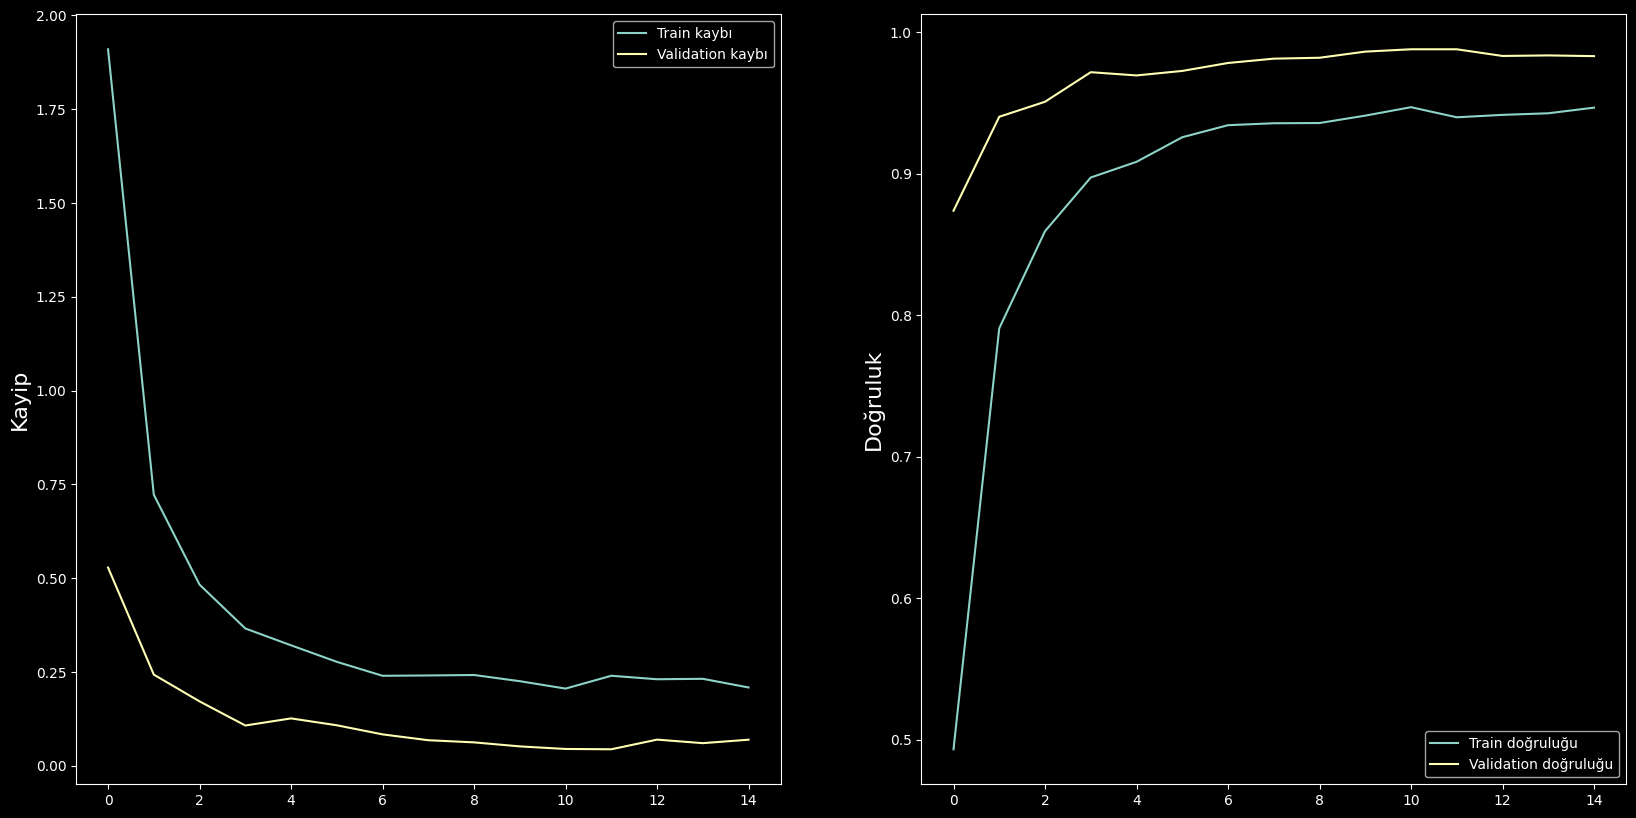

In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
##plt.suptitle('Optimizer : Adam', fontsize=10)##
plt.ylabel('Kayip', fontsize=16)
plt.plot(history.history['loss'], label='Train kaybı')
plt.plot(history.history['val_loss'], label='Validation kaybı')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Doğruluk', fontsize=16)
plt.plot(history.history['accuracy'], label='Train doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validation doğruluğu')
plt.legend(loc='lower right')
plt.show()

In [11]:
# Modeli test veri kümesi ile test etme. Daha önce ayırdığımız test.csv klasöründe test verilerimiz bulunmakta.
# Pandas kütüphanesi ile görüntü yolunu ve etiketini çıkarıyoruz.

from sklearn.metrics import accuracy_score

y_test = pd.read_csv('Test.csv')

etiketler = y_test["ClassId"].values

fotolar = y_test["Path"].values

veriler = []

# modeli tahmin etmek için görüntüleri 30x30 piksel olarak yeniden boyutlandırıyorum. Daha sonra tüm görüntü verilerini içeren bir numpy dizisi oluşturuyorum.

for foto in fotolar:
    fotograf = Image.open(foto)
    fotograf = fotograf.resize((30, 30))
    veriler.append(np.array(fotograf))

X_test = np.array(veriler)

tahmin = model.predict(X_test)
xSiniflari = np.argmax(tahmin,axis=1)
print(xSiniflari)
#predict_x=model.predict(X_test) 
#classes_x=np.argmax(predict_x,axis=1)

# Test verisi ile doğruluk. sklearn.metrics ten doğruluk skorunu içeri aktardıkve modelimizin gerçek etiketleri nasıl
# tahmin ettiğini gözlemledik.
from sklearn.metrics import accuracy_score

print(accuracy_score(etiketler, xSiniflari))

# Modelimiz %95 doğrulukla çalışıyor

395/395 [==============================] - 4s 9ms/step
[16  1 38 ...  2  7 10]
0.9583531274742676


In [12]:
siniflar = { 1:'Azami Hız Sınırı (20km/sa)',
           2:'Azami Hız Sınırı (30km/sa)',
           3:'Azami Hız Sınırı (50km/sa)',
           4:'Azami Hız Sınırı (60km/sa)',
           5:'Azami Hız Sınırı (70km/sa)',
           6:'Azami Hız Sınırı (80km/sa)',
           7:'Hız Limitinin Sonu (80km/sa)',
           8:'Azami Hız Sınırı (100km/sa)',
           9:'Azami Hız Sınırı (120km/sa)',
           10:'Öndeki aracı geçmek yasaktır',
           11:'Yük Taşıtlarının Öndeki Aracı Geçmesi Yasaktır',
           12:'Ana Yol-Tali Yol Kavşağı',
           13:'Anayol',
           14:'Yol Ver',
           15:'DUR',
           16:'Taşıt Trafiğine Kapalı Yol',
           17:'Kamyon Giremez',
           18:'Girişi Olmayan Yol',
           19:'Dikkat',
           20:'Sola Tehlikeli Viraj',
           21:'Sağa Tehlikeli Viraj',
           22:'Sola Tehlikeli Devamlı Virajlar',
           23:'Kasisli Yol',
           24:'Kaygan Yol',
           25:'Soldan Daralan Kaplama',
           26:'Yolda Çalışma',
           27:'Işıklı İşaret Cihazı',
           28:'Yaya Geçidi',
           29:'Çocuklar Geçebilir',
           30:'Bisiklet Geçebilir',
           31:'Gizli Buzlanma',
           32:'Vahşi Hayvan Geçebilir',
           33:'Bütün Yasaklama ve Kısıtlamaların Sonu',
           34:'İleride Sağa Mecburi Yön',
           35:'İleride Sola Mecburi Yön',
           36:'İleri Mecburi Yön',
           37:'İleri ve Sağa Mecburi Yön',
           38:'İleri ve Sola Mecburi Yön',
           39:'Sağdan Gidiniz',
           40:'Soldan Gidiniz',
           41:'Ada Etrafında Dönünüz',
           42:'Geçme Yasağı Sonu',
           43:'Yük Taşıtları ile Geçme Yasağının Sonu' }

<Axes: >

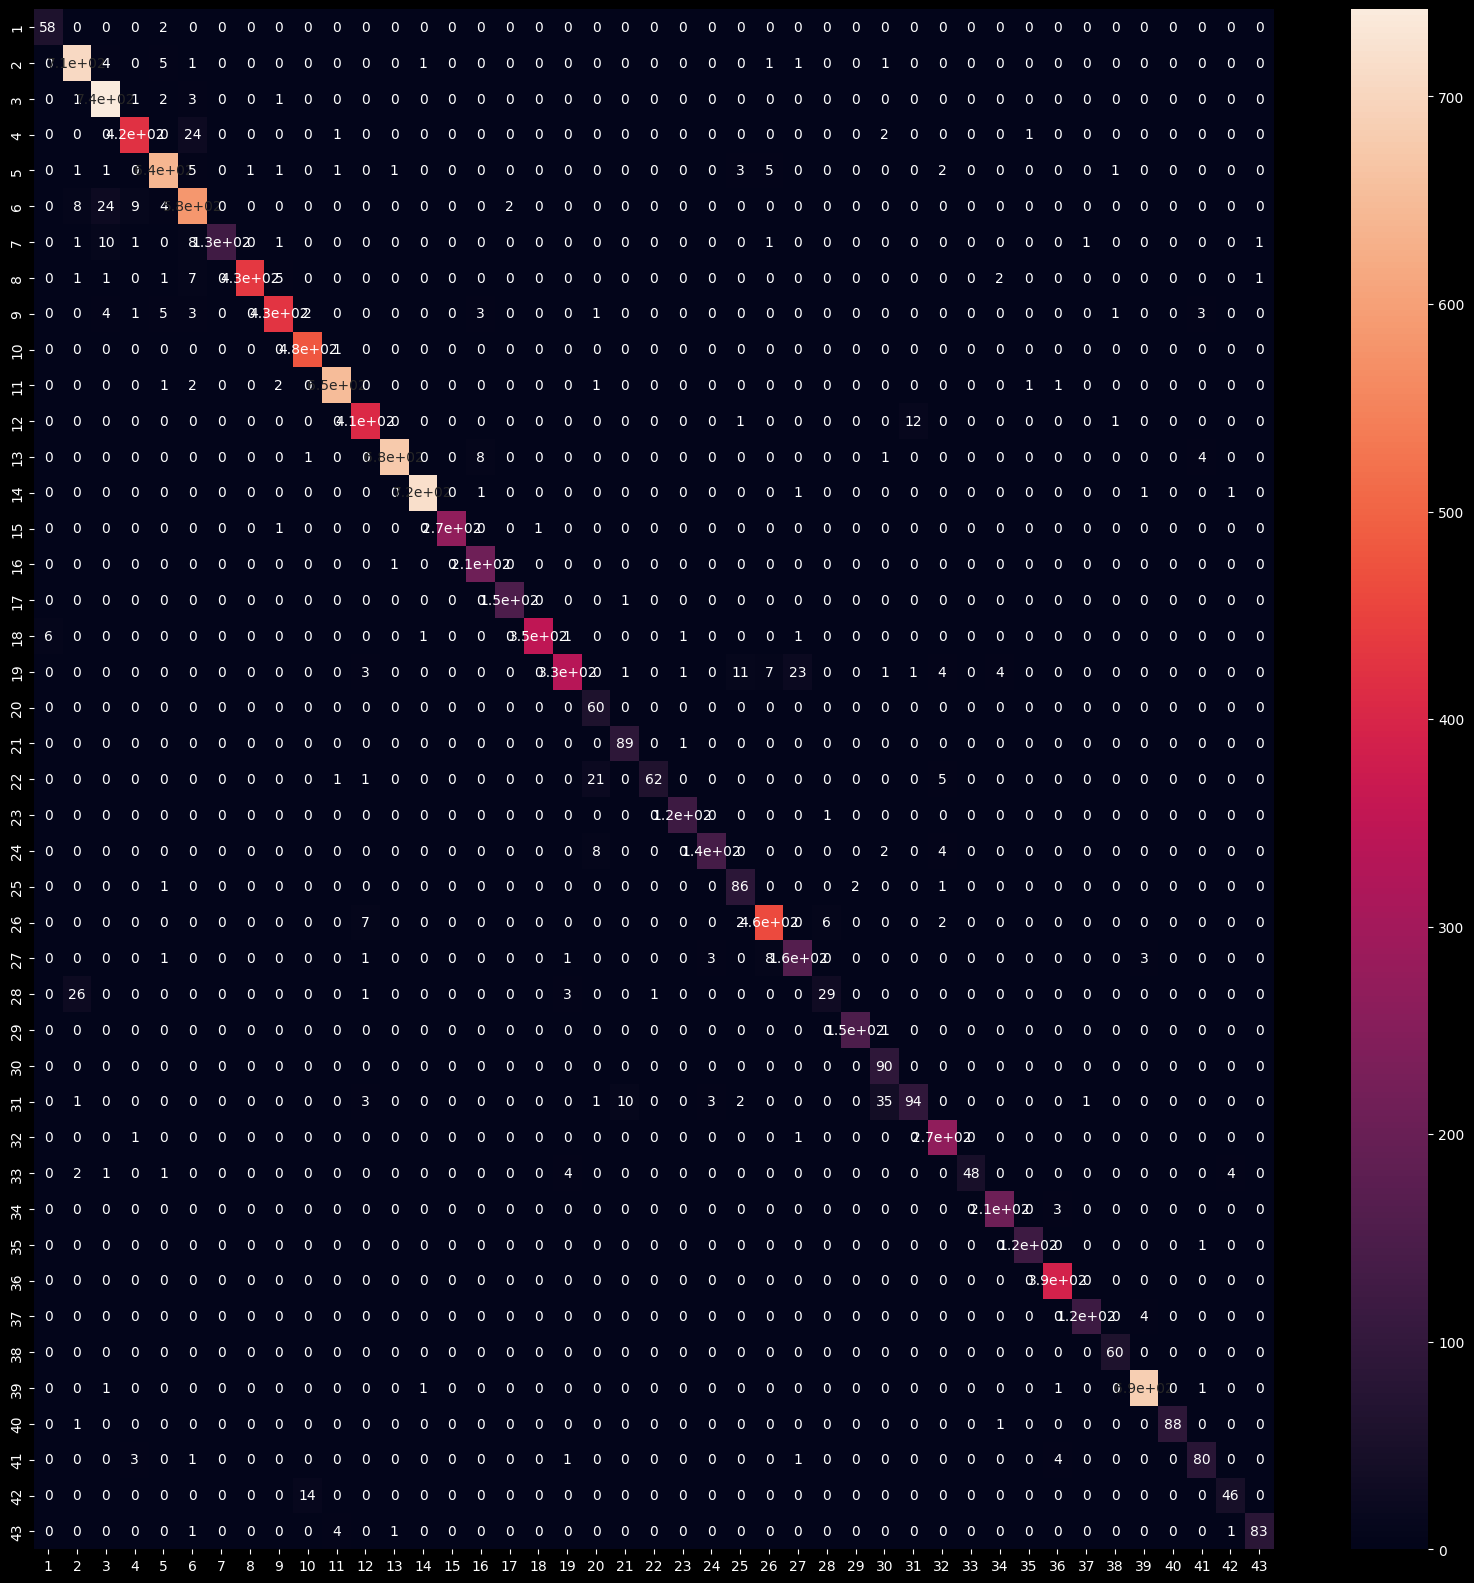

In [13]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(etiketler, xSiniflari)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = siniflar,  columns = siniflar)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [14]:
import pickle
model.save('model.h5')
pickle_out = open("model.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()